Solve for homogeneous Poisson problems using FEANet framework 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import h5py
import meshio
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.model import KNet, FNet
from Utils import plot

In [2]:
class JacobiBlockPBC():
    """ Define all the methods necessary for a CNN-based Jacobi iteration (periodic boundary condition); currently only for homogeneous problems
        
        Knet: neural network model for stiffness terms
    """
    def __init__(self, mesh, Knet=None, omega=2./3.):
        self.nnode_edge = mesh.nnode_edge 
        self.omega = omega
        self.mesh = mesh
        self.d_mat = torch.zeros((1,1,self.nnode_edge, self.nnode_edge)) # Diagonal matrix for Jacobi iteration
        self.compute_diagonal_matrix()
        self.Knet = Knet # Initialize the stiffness network, given mesh

    def compute_diagonal_matrix(self):
        """ Comopute diagonal matrix for Jacobi iteration """
        for i in range(self.d_mat.shape[0]):
            for pkey in self.mesh.kernel_dict:
                K_weights = torch.from_numpy(self.mesh.kernel_dict[pkey]) ## 3x3 size kernel
                global_pattern = torch.from_numpy(self.mesh.global_pattern_center[pkey]).reshape(self.nnode_edge, self.nnode_edge)
                self.d_mat[i,0,:,:] += global_pattern*K_weights[1,1] 

    def pbc_boundary(self, u):
        """ 
        Expand the domain boundary to be periodic
        Input size [n, n]; output size [n+2, n+2]
        """
        u_central = u[:,:,:-1,:-1]
        return F.pad(u_central, (1,2,1,2), 'circular')

    def reset_boundary(self, u):
        """ 
        Copy the boundary values to be the same
        Input size [n, n]; output size [n, n]
        """
        u_central = u[:,:,:-1,:-1]
        return F.pad(u_central, (0,1,0,1), 'circular')

    def jacobi_iteration_step(self, u, forcing_term):
        """ 
        Jacobi method iteration step defined as a convolution:
        u_new = omega/d_mat*residual + u, where residual = f - K*u (* is convolution operator here)
        note that the forcing_term should be already convoluted, i.e., forcing_term = fnet(f), when source term is f
        """
        u_pbc = self.pbc_boundary(u)
        residual = forcing_term-self.Knet(u_pbc)
        residual = residual[:,:,1:-1,1:-1] # due to padding = 1, need to remove the most outside boundary layer of residual
        u_new = self.omega/self.d_mat*residual + u
        return self.reset_boundary(u_new)

    def jacobi_convolution(self, initial_u, forcing_term, n_iter = 1000):
        """ Compute jacobi method solution by convolution. 

            Return: 
                u """

        u = initial_u
        for i in range(n_iter):
            u = self.jacobi_iteration_step(u, forcing_term)

        return u 

In [3]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, n, f = None, size=2.0):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.InstantiateFEANet()
        self.jac = JacobiBlockPBC(self.grid, self.Knet, self.omega)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)

        if(f is None):
            f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = self.fnet(self.jac.pbc_boundary(f))

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v


In [4]:
# Problem parameters
n = 2**5

x = torch.linspace(-1,1,n+1)
y = torch.linspace(-1,1,n+1)
xx, yy = torch.meshgrid(x, y, indexing='ij')

rhs = torch.sin(1.*torch.pi*(xx+0.5))*torch.cos(1.*torch.pi*(yy)).reshape((1,1,n+1,n+1))
prob = SingleGrid(n, rhs)

In [8]:
EPS = 1e-6
u_jacobi = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
u_jacobi_pbc = prob.jac.pbc_boundary(u_jacobi)

residual = prob.f-prob.Knet(u_jacobi_pbc)
u_jacobi = prob.jac.reset_boundary(u_jacobi)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_jacobi = [res]

n_jacobi = 0
while (res>EPS):
    u_jacobi = prob.Relax(u_jacobi, prob.f, 1)
    u_jacobi_pbc = prob.jac.pbc_boundary(u_jacobi)
    residual = prob.f-prob.Knet(u_jacobi_pbc)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_jacobi.append(res)
    n_jacobi += 1
    print(n_jacobi, res)

print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

1 0.05492521822452545
2 0.052453137934207916
3 0.050217192620038986
4 0.04816577956080437
5 0.04626573249697685
6 0.044493984431028366
7 0.04283352941274643
8 0.04127131775021553
9 0.03979697823524475
10 0.03840205818414688
11 0.03707951307296753
12 0.03582339361310005
13 0.03462856635451317
14 0.03349056839942932
15 0.03240547701716423
16 0.03136980161070824
17 0.030380429700016975
18 0.029434548690915108
19 0.028529606759548187
20 0.02766328491270542
21 0.02683345600962639
22 0.026038167998194695
23 0.025275614112615585
24 0.0245441272854805
25 0.02384215034544468
26 0.023168236017227173
27 0.02252102829515934
28 0.021899282932281494
29 0.021301792934536934
30 0.02072746492922306
31 0.020175231620669365
32 0.0196441151201725
33 0.019133172929286957
34 0.01864153891801834
35 0.018168367445468903
36 0.017712868750095367
37 0.017274294048547745
38 0.016851922497153282
39 0.016445090994238853
40 0.016053147614002228
41 0.01567547395825386
42 0.01531149260699749
43 0.014960650354623795
44

Multigrid solution:


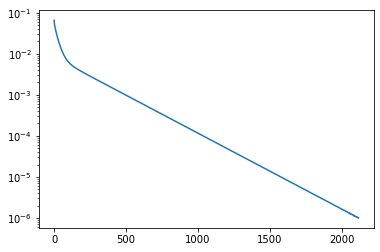

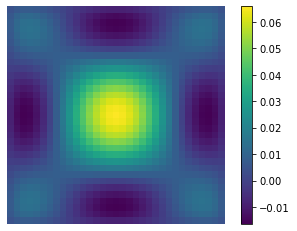

In [10]:
plt.plot(res_jacobi)
plt.yscale('log')

print("Multigrid solution:")
plot.plot_field(u_jacobi.detach())
